In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, recall_score

In [ ]:
# Check cuda status
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_df = pd.read_csv("../data/combined_split/train_split.csv")
val_df = pd.read_csv("../data/combined_split/val_split.csv")
test_df = pd.read_csv("../data/combined_split/test_split.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(f'shape of train data is {train_df.shape}')
print(f'shape of test data is {val_df.shape}')
print(f'shape of test data is {test_df.shape}')

shape of train data is (8165, 3)
shape of test data is (1167, 3)
shape of test data is (2333, 3)


In [ ]:
nltk.download('stopwords')

# Tokenization
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s.strip().lower()

def tokenize_text(train_df, val_df, test_df, vocab_size=1000):
    word_list = []
    stop_words = set(stopwords.words('english'))

    for text in train_df['text']:
        for word in text.split():
            word = preprocess_string(word)
            if word and word not in stop_words:
                word_list.append(word)

    corpus = Counter(word_list)
    top_words = sorted(corpus, key=corpus.get, reverse=True)[:vocab_size]
    onehot_dict = {w: i+1 for i, w in enumerate(top_words)}

    def tokenize_column(df):
        tokenized = []
        for text in df['text']:
            tokens = [onehot_dict[preprocess_string(word)]
                      for word in text.split()
                      if preprocess_string(word) in onehot_dict]
            tokenized.append(tokens)
        return np.array(tokenized, dtype=object)


    x_train_tokens = tokenize_column(train_df)
    x_val_tokens   = tokenize_column(val_df)
    x_test_tokens  = tokenize_column(test_df)

    y_train = train_df['label'].values
    y_val   = val_df['label'].values
    y_test  = test_df['label'].values

    return x_train_tokens, y_train, x_val_tokens, y_val, x_test_tokens, y_test, onehot_dict

x_train, y_train, x_val, y_val, x_test, y_test, vocab = tokenize_text(train_df, val_df, test_df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(f'Length of vocabulary is {len(vocab)}')


Length of vocabulary is 1000


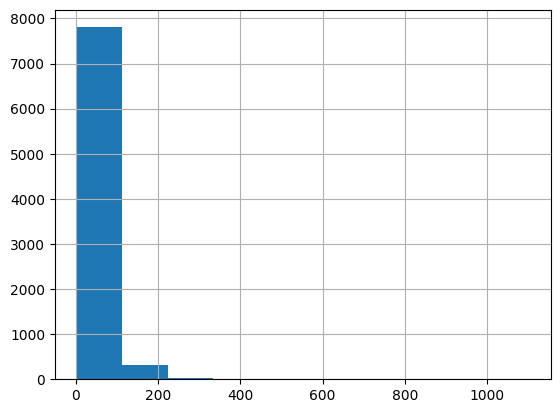

,0
count,8165.000000
mean,43.508757
std,39.088507
min,4.000000
25%,21.000000
50%,33.000000
75%,52.000000
max,1100.000000


In [ ]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

count = 8165 -> There are 8165 training samples. <br>
mean = 43.51 -> On average, each review has around 44 tokens. <br>
std = 39.1 -> There’s large standard deviation. Some reviews are very short while some are very long. <br>
min = 4	-> The shortest review has only 4 tokens. <br>
25% = 21 -> 25% of reviews have ≤ 21 tokens. <br>
50% = 33 -> Half of the reviews have ≤ 33 tokens. <br>
75% = 52 -> 75% of reviews have ≤ 52 tokens. <br>
max = 1100 -> The longest review is 1100 tokens long

In [ ]:
print('\n Text input: {}\n'.format(x_train[0]))


 Text input: [127, 109, 7, 26, 917, 157, 263, 762, 750, 392, 127, 905, 750, 127, 50, 50, 170, 608, 58, 613, 97, 224, 776, 192]



In [ ]:
for p in [90, 95, 99]:
    print(f"{p}th percentile length: {np.percentile(rev_len, p):.0f}")

90th percentile length: 83
95th percentile length: 109
99th percentile length: 187


In [ ]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

#we have very less number of reviews with length > 120 as the 95th percentile length is 106.
#So we will consider only those below it.
x_train_pad = padding_(x_train, 120)
x_val_pad   = padding_(x_val, 120)
x_test_pad  = padding_(x_test, 120)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_val   = le.transform(y_val)
y_test  = le.transform(y_test)

print(le.classes_)  #should print ['negative' 'neutral' 'positive']

['negative' 'neutral' 'positive']


In [ ]:
train_data = TensorDataset(
    torch.from_numpy(x_train_pad),
    torch.from_numpy(y_train)
)

val_data = TensorDataset(
    torch.from_numpy(x_val_pad),
    torch.from_numpy(y_val)
)

test_data = TensorDataset(
    torch.from_numpy(x_test_pad),
    torch.from_numpy(y_test)
)

batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader   = DataLoader(val_data,   shuffle=True, batch_size=batch_size)
test_loader  = DataLoader(test_data,  shuffle=False, batch_size=batch_size)

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample sentences x: \n', sample_x)
print('Sample targets y: \n', sample_y)

Sample input size:  torch.Size([50, 120])
Sample sentences x: 
 tensor([[  0,   0,   0,  ...,   4, 111,  13],
        [  0,   0,   0,  ..., 345, 489, 155],
        [  0,   0,   0,  ..., 132, 542, 102],
        ...,
        [  0,   0,   0,  ...,  52,  40,   5],
        [997,   2,  36,  ...,   8,   9,   3],
        [  0,   0,   0,  ...,  22,  48, 368]])
Sample targets y: 
 tensor([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 2, 2,
        2, 2])


In [ ]:
class SentimentRNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim=128,
        hidden_dim=128,
        num_layers=2,
        num_classes=3,         #3 classes from le()
        bidirectional=True,
        dropout=0.3,
        pad_idx=0               #padding index is 0
    ):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_dim * self.num_directions, num_classes)

    def forward(self, x, hidden):
        emb = self.embedding(x)
        lstm_out, hidden = self.lstm(emb, hidden)
        last_hidden = lstm_out[:, -1, :]
        out = self.dropout(last_hidden)
        logits = self.fc(out)          # [B, 3]
        return logits, hidden          # CE expects raw logits + int targets


    def init_hidden(self, batch_size, device):
        h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_dim, device=device)
        return (h0, c0)

In [ ]:
vocab_size = len(vocab) + 1      # +1 for PAD=0
model = SentimentRNN(
    vocab_size=vocab_size,
    embedding_dim=96,
    hidden_dim=96,
    num_layers=2,
    num_classes=3,
    bidirectional=True,
    dropout=0.3,
    pad_idx=0
).to(device)

lr=0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def acc(pred, label):
    pred_class = torch.argmax(pred, dim=1)
    correct = torch.sum(pred_class == label).item()
    return correct

In [ ]:
clip = 5
epochs = 6

valid_loss_min = np.inf

epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc,  epoch_vl_acc  = [], []

for epoch in range(epochs):
  # training
    model.train()
    train_losses = []
    train_acc = 0  # count of correct predictions

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        h = model.init_hidden(batch_size=inputs.size(0), device=device)

        optimizer.zero_grad()
        logits, h = model(inputs, h)
        loss = criterion(logits, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())
        train_acc += acc(logits, labels)

    # validation
    model.eval()
    val_losses = []
    val_acc = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            h = model.init_hidden(batch_size=inputs.size(0), device=device)

            logits, h = model(inputs, h)
            val_loss = criterion(logits, labels)
            val_losses.append(val_loss.item())
            val_acc += acc(logits, labels)

    # ---- EPOCH METRICS ----
    epoch_train_loss = float(np.mean(train_losses)) if train_losses else 0.0
    epoch_val_loss   = float(np.mean(val_losses))   if val_losses   else 0.0
    epoch_train_acc  = train_acc / len(train_loader.dataset)
    epoch_val_acc    = val_acc   / len(val_loader.dataset)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    print(f"Epoch {epoch+1}")
    print(f"train_loss: {epoch_train_loss}  val_loss: {epoch_val_loss}")
    print(f"train_acc : {epoch_train_acc*100}%  val_acc : {epoch_val_acc*100}%")
    print(25*'==')

    if epoch_val_loss < valid_loss_min:
        valid_loss_min = epoch_val_loss
        # torch.save(model.state_dict(), "best.pt")

Epoch 1
train_loss: 0.6382562329129475  val_loss: 0.5151971442004045
train_acc : 76.39926515615431%  val_acc : 79.34875749785776%
Epoch 2
train_loss: 0.4508618046416015  val_loss: 0.47368205276628333
train_acc : 82.90263319044703%  val_acc : 82.09083119108827%
Epoch 3
train_loss: 0.38387327950175215  val_loss: 0.42706238354245823
train_acc : 85.3153704837722%  val_acc : 83.54755784061697%
Epoch 4
train_loss: 0.34092626202760673  val_loss: 0.465048935264349
train_acc : 86.62584200857317%  val_acc : 83.29048843187661%
Epoch 5
train_loss: 0.3031915070988783  val_loss: 0.5155874391396841
train_acc : 88.30373545621556%  val_acc : 82.60497000856898%
Epoch 6
train_loss: 0.2573274951428175  val_loss: 0.4830886423587799
train_acc : 90.18983466013472%  val_acc : 83.29048843187661%


In [27]:
from sklearn.metrics import f1_score
import torch.nn.functional as F

def evaluate_split(model, loader, device):
    model.eval()
    total_correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            h = model.init_hidden(batch_size=inputs.size(0), device=device)
            logits, h = model(inputs, h)
            preds = torch.argmax(F.softmax(logits, dim=1), dim=1)

            total_correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = total_correct / total
    f1m = f1_score(all_labels, all_preds, average='macro')
    return acc, f1m


val_acc, val_f1 = evaluate_split(model, val_loader, device)
test_acc, test_f1 = evaluate_split(model, test_loader, device)

print(
    f"Validation Accuracy: {val_acc*100:.2f}%  "
    f"Validation Macro-F1: {val_f1:.4f}  "
    f"Test Accuracy: {test_acc*100:.2f}%  "
    f"Test Macro-F1: {test_f1:.4f}"
)


Validation Accuracy: 83.29%  Validation Macro-F1: 0.6404  Test Accuracy: 82.77%  Test Macro-F1: 0.6414
